In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import gymnasium as gym
import gym_trading_env
from gym_trading_env.environments import (
    dynamic_feature_last_position_taken,
    dynamic_feature_real_position  # you can import it if you ever need it
)

from RLTrade.agent import DQNAgent, XGBoostAgent
from RLTrade.utils import (
    stationary_prob_model, 
    make_ohlc,
    FeatureEngineering,
    excess_return_metric,
    extract_signals,
)
from RLTrade.plot_utils import (
    plot_candlestick_subplots,
    plot_metrics_subplots,
    build_fig,
    plot_signals_distribution,
)

### Details of the simulation
Consider two cointegrated price series $X_t = X_{t-1} + e_t; e_t \sim N(0, \sigma^2)$ is a random walk; and $Y_t = X_t + \epsilon_t$ where $\epsilon_t$ is a stationary mean reverting signal generated by Ornstein–Uhlenbeck process, it is basically an autoregressive noise. 

$X_t$ and $Y_t$ are both non-stationary and integrated of order 1 - I(1).

But the resultant paris trading portfolio $Y - X = \epsilon_t$ is a stationary process - I(0) and is mean reverting

### Details of the environment and trading agent
This is the most simplified case, the agent sees only two features, i.e. the state is 2-D:
- the close price of today
- the position taken today

It then performs 1 of the 3 actions precisely at the market close time today (or at the market open time tomorrow, assuming there is no after hours)
- -1: SHORT
- 0: EXIT
- 1: LONG

The reward of this environment is the log-return of portfolio value at each time step, so the model is simply optimised for maximising portfolio value at each time step.

The agents are model-based Q Learning algorithms, i.e. they will use an internal model to estimate to Q-value for each (state, action)-pair. And they will choose actions based on Q-value using epsilon-greedy algoritm during training, and greedy algorithm during inference/evaluation.

Two types of common model are used:
- XGBoost: Expect to learn quicker but may overfit, also less feature engineering needed
- Fully-connected NN: Expect to generalise better but requires more attention to feature engineering and model architecture

In [2]:
x0, mu_epsilon = 100, 200

N, window, stride = 100000, 24, 24  # simulation with ohlc
# N, window, stride = 10000, 1, 1  # simulation with tick data

train_set_random_state = 42
x_c, y_c = stationary_prob_model(N=N, x0=x0, mu=mu_epsilon, random_state=train_set_random_state)
y_o, y_h, y_l, y_c = make_ohlc(y_c, window=window, stride=stride)
x_o, x_h, x_l, x_c = make_ohlc(x_c, window=window, stride=stride)
spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c
# spread_o, spread_h, spread_l, spread_c = x_o, x_h, x_l, x_c  # test on random walk

df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

In [3]:
plot_candlestick_subplots(
    data_list=[
        (x_o, x_h, x_l, x_c),
        (y_o, y_h, y_l, y_c),
        (spread_o, spread_h, spread_l, spread_c)
    ],
    titles=['X', 'Y', 'Y - X'],
    x_index=df.index,
)

0.002199959074487561 0.0012822398621351264


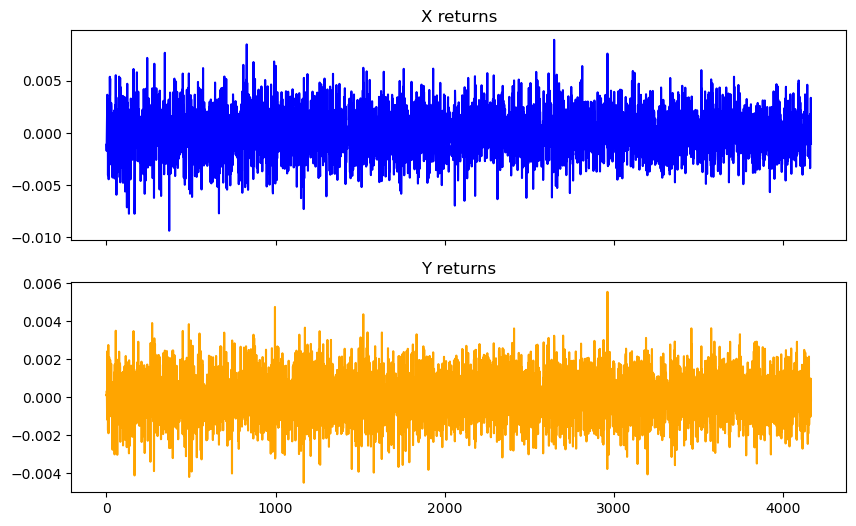

In [4]:
# plot volatility of X and Y
x_rets = np.diff(x_c) / x_c[:-1]
y_rets = np.diff(y_c) / y_c[:-1]
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axs[0].plot(x_rets, label='X returns', color='blue')
axs[0].set_title('X returns')
axs[1].plot(y_rets, label='Y returns', color='orange')
axs[1].set_title('Y returns')

print(np.std(x_rets), np.std(y_rets))

In [5]:
# confirm the x, y pair is correlated, i.e. Z_t = Y_t - beta * X_t can be fitted with a significant beta
x_ols = sm.add_constant(x_c)
ols = sm.OLS(y_c, x_ols).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 7.197e+06
Date:                Thu, 15 May 2025   Prob (F-statistic):               0.00
Time:                        21:19:36   Log-Likelihood:                 187.05
No. Observations:                4166   AIC:                            -370.1
Df Residuals:                    4164   BIC:                            -357.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        199.9724      0.042   4715.075      0.0

In [6]:
# Confirm the spread (residual of Y - X) is stationary
adfuller_test = adfuller(spread_c)
print(f'ADF Statistic: {adfuller_test[0]}')
print(f'p-value: {adfuller_test[1]}')
print('Is the spread stationary? {}'.format('Yes' if adfuller_test[1] < 0.05 else 'No'))

ADF Statistic: -59.2862851067775
p-value: 0.0
Is the spread stationary? Yes


### Demo: Using Deep Q-Learning on the spread (with feature engineering of moving window mean correction)

In [7]:
feature_config = [
    {'type': 'rolling_mean_corrected',
     'params': {
       'cols': ['close'],
       'window': 100,
     }},
]

df_train = df.copy()
fe = FeatureEngineering(df_train)
df_train = fe.build_features(feature_config)
df_train

,open,high,low,close,feature_close_rolling_mean_corrected
2020-01-01,199.986174,200.549237,199.319746,199.802509,0.000000
2020-01-02,199.645954,200.435982,199.612046,199.948100,0.072796
2020-01-03,199.979395,200.403368,199.656875,200.142213,0.177939
2020-01-04,200.206174,200.651949,199.902046,200.274014,0.232305
2020-01-05,200.122038,200.695065,199.800625,200.171634,0.103940
...,...,...,...,...,...
2031-05-24,200.289505,200.562267,199.683165,200.403368,0.406366
2031-05-25,200.328411,200.867773,199.559922,200.168429,0.166812
2031-05-26,200.196776,200.803471,199.726151,200.041121,0.039671
2031-05-27,200.228767,200.609699,199.439465,199.930831,-0.070199


In [8]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationary_prob_model",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        dynamic_feature_functions = [dynamic_feature_last_position_taken],
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Excess Return', lambda history: f"{np.round(excess_return_metric(history) * 100, 2)}%")
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)

while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(position_index)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[ 0. -1.]
Market Return :  0.11%   |   Portfolio Return : -33.05%   |   Excess Return : -40.39%   |   Position Changes : 2775   |   Episode Length : 4166   |   


In [9]:
# Train a DQN agent using training data from a stationary data generating process
agent = DQNAgent(n_observations=n_observations, n_actions=n_actions, target_net_layers=[8], policy_net_layers=[8])
history_metrics, _ = agent.train(env, num_episodes=15) # Beware of overfitting when num_episodes is too high

Market Return :  0.11%   |   Portfolio Return : 19.81%   |   Excess Return : 17.83%   |   Position Changes : 2590   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 108.21%   |   Excess Return : 73.11%   |   Position Changes : 2279   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 779.76%   |   Excess Return : 217.25%   |   Position Changes : 1931   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 1404.60%   |   Excess Return : 270.93%   |   Position Changes : 2325   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 1599.47%   |   Excess Return : 283.13%   |   Position Changes : 2152   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 1718.15%   |   Excess Return : 289.88%   |   Position Changes : 2145   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 1583.78%   |   Excess Return : 282.2%   |   Po

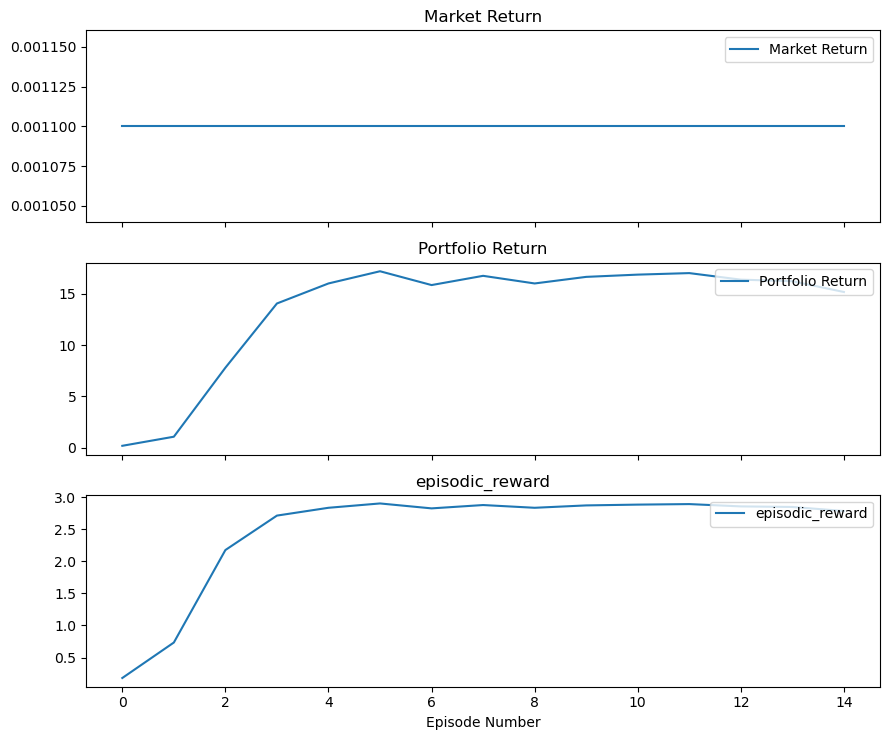

In [10]:
all_metrics = pd.DataFrame(history_metrics)
# Clean percentage columns before plotting
perc2float = lambda x: float(x.strip('%')) / 100
all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

plot_metrics_subplots(all_metrics, ["Market Return", "Portfolio Return", "episodic_reward"])

In [11]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
history_dfs = []
for i in range(10):
    x_c, y_c = stationary_prob_model(N=N, x0=x0, mu=mu_epsilon, random_state=i*1234)
    y_o, y_h, y_l, y_c = make_ohlc(y_c, window=window, stride=stride)
    x_o, x_h, x_l, x_c = make_ohlc(x_c, window=window, stride=stride)
    spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c
    # spread_o, spread_h, spread_l, spread_c = x_o, x_h, x_l, x_c  # test on random walk

    _df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
    _df["volume"] = 0
    _df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

    fe = FeatureEngineering(_df)
    _df = fe.build_features(feature_config)
    
    env_test = gym.make("TradingEnv",
            name= "stationary_prob_model_qlearning",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            dynamic_feature_functions = [dynamic_feature_last_position_taken],
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Excess Return', lambda history: f"{np.round(excess_return_metric(history) * 100, 2)}%")
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))
    history_dfs.append(pd.DataFrame(list(env_test.unwrapped.historical_info)))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  0.22%   |   Portfolio Return : 1808.55%   |   Excess Return : 294.61%   |   Position Changes : 2314   |   Episode Length : 4166   |   
Market Return : -0.02%   |   Portfolio Return : 1698.00%   |   Excess Return : 288.88%   |   Position Changes : 2231   |   Episode Length : 4166   |   
Market Return :  0.39%   |   Portfolio Return : 1610.37%   |   Excess Return : 283.47%   |   Position Changes : 2220   |   Episode Length : 4166   |   
Market Return : -0.10%   |   Portfolio Return : 1740.16%   |   Excess Return : 291.29%   |   Position Changes : 2248   |   Episode Length : 4166   |   
Market Return :  0.13%   |   Portfolio Return : 1636.37%   |   Excess Return : 285.23%   |   Position Changes : 2268   |   Episode Length : 4166   |   
Market Return : -0.06%   |   Portfolio Return : 1645.65%   |   Excess Return : 285.97%   |   Position Changes : 2257   |   Episode Length : 4166   |   
Market Return :  0.01%   |   Portfolio Return : 2020.99%   |   Excess Return : 305.37%  

In [12]:
# env_test.unwrapped.save_for_render(dir = "render_logs")

historical_info_df = history_dfs[-1]
historical_info_df.columns

Index(['idx', 'step', 'date', 'position_index', 'position', 'real_position',
       'data_volume', 'data_close', 'data_high', 'data_low', 'data_open',
       'portfolio_valuation', 'portfolio_distribution_asset',
       'portfolio_distribution_fiat', 'portfolio_distribution_borrowed_asset',
       'portfolio_distribution_borrowed_fiat',
       'portfolio_distribution_interest_asset',
       'portfolio_distribution_interest_fiat', 'reward'],
      dtype='object')

In [13]:
buy_df_qlearning, sell_df_qlearning, exit_df_qlearning = extract_signals(historical_info_df)
fig_qlearning = build_fig(
    historical_info_df,
    buy_df_qlearning,
    sell_df_qlearning,
    exit_df_qlearning
)
fig_qlearning.show()

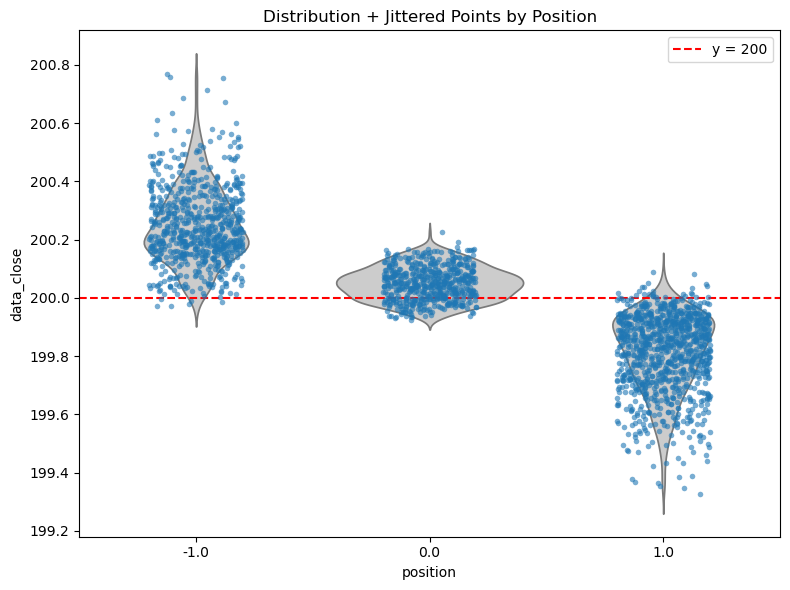

In [14]:
signals_df_qlearning = pd.concat([buy_df_qlearning, sell_df_qlearning, exit_df_qlearning])
plot_signals_distribution(signals_df_qlearning, threshold=mu_epsilon)

### Demo: Using XGBoost model-based Q-Learning on the spread (with no feature engineering)

In [15]:
# build features
df_train = df.copy()

feature_config = [
    {'type': 'select',
     'params': {
         'cols': ['close'],
     }}
]

fe = FeatureEngineering(df_train)
fe.build_features(feature_config)
df_train = fe.df.copy()
df_train

,open,high,low,close,feature_close
2020-01-01,199.986174,200.549237,199.319746,199.802509,199.802509
2020-01-02,199.645954,200.435982,199.612046,199.948100,199.948100
2020-01-03,199.979395,200.403368,199.656875,200.142213,200.142213
2020-01-04,200.206174,200.651949,199.902046,200.274014,200.274014
2020-01-05,200.122038,200.695065,199.800625,200.171634,200.171634
...,...,...,...,...,...
2031-05-24,200.289505,200.562267,199.683165,200.403368,200.403368
2031-05-25,200.328411,200.867773,199.559922,200.168429,200.168429
2031-05-26,200.196776,200.803471,199.726151,200.041121,200.041121
2031-05-27,200.228767,200.609699,199.439465,199.930831,199.930831


In [16]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationary_prob_model",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        dynamic_feature_functions = [dynamic_feature_last_position_taken],
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Excess Return', lambda history: f"{np.round(excess_return_metric(history) * 100, 2)}%")
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(0)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[199.8025   0.    ]
Market Return :  0.11%   |   Portfolio Return : -0.12%   |   Excess Return : -0.22%   |   Position Changes : 1   |   Episode Length : 4166   |   


In [17]:
agent = XGBoostAgent(n_observations, n_actions)
history_metrics, _ = agent.train(env, num_episodes=20, replay_every=2)

Market Return :  0.11%   |   Portfolio Return : -31.43%   |   Excess Return : -37.99%   |   Position Changes : 2757   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : -25.39%   |   Excess Return : -29.57%   |   Position Changes : 2824   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 180.38%   |   Excess Return : 102.86%   |   Position Changes : 2677   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 194.00%   |   Excess Return : 107.6%   |   Position Changes : 2710   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 672.20%   |   Excess Return : 204.21%   |   Position Changes : 2542   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 670.30%   |   Excess Return : 203.95%   |   Position Changes : 2534   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 1052.80%   |   Excess Return : 244.29%   |   Po

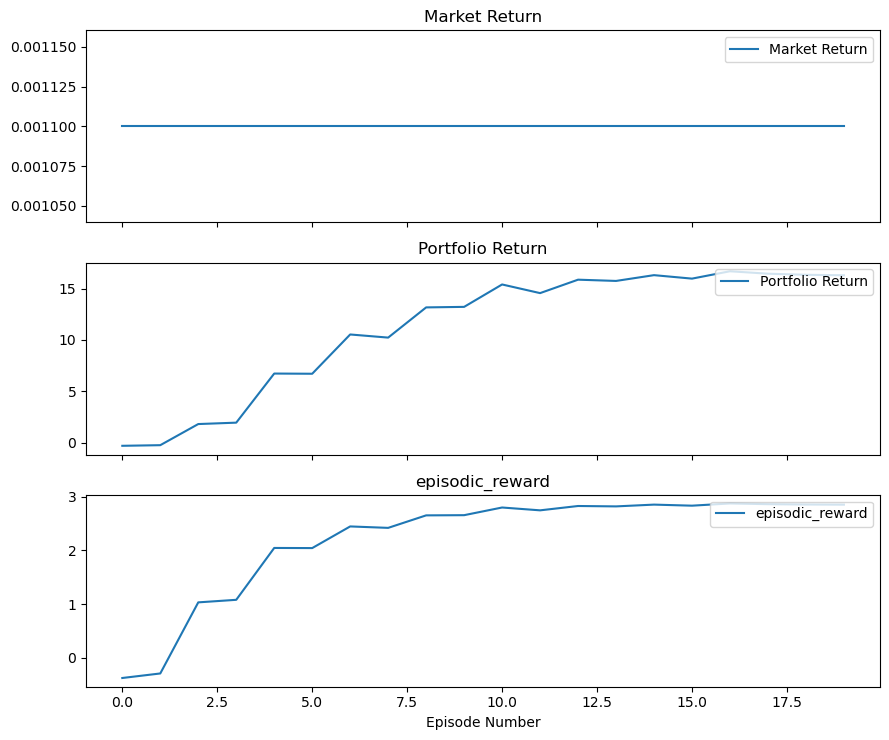

In [18]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100
all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

plot_metrics_subplots(all_metrics, ["Market Return", "Portfolio Return", "episodic_reward"])

In [19]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
history_dfs = []
for i in range(10):
    x_c, y_c = stationary_prob_model(N=N, x0=x0, mu=mu_epsilon, random_state=i*1234)
    y_o, y_h, y_l, y_c = make_ohlc(y_c, window=window, stride=stride)
    x_o, x_h, x_l, x_c = make_ohlc(x_c, window=window, stride=stride)
    spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c
    # spread_o, spread_h, spread_l, spread_c = x_o, x_h, x_l, x_c  # test on random walk

    _df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
    _df["volume"] = 0
    _df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')
    fe = FeatureEngineering(_df)
    fe.build_features(feature_config)
    _df = fe.df.copy()

    env_test = gym.make("TradingEnv",
            name= "stationary_prob_model_xgboost",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
            dynamic_feature_functions = [dynamic_feature_last_position_taken],
        )
    env_test.unwrapped.add_metric('Excess Return', lambda history: f"{np.round(excess_return_metric(history) * 100, 2)}%")
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))
    history_dfs.append(pd.DataFrame(list(env_test.unwrapped.historical_info)))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  0.22%   |   Portfolio Return : 1336.84%   |   Excess Return : 266.21%   |   Position Changes : 2289   |   Episode Length : 4166   |   
Market Return : -0.02%   |   Portfolio Return : 1472.95%   |   Excess Return : 275.51%   |   Position Changes : 2305   |   Episode Length : 4166   |   
Market Return :  0.39%   |   Portfolio Return : 1414.46%   |   Excess Return : 271.3%   |   Position Changes : 2284   |   Episode Length : 4166   |   
Market Return : -0.10%   |   Portfolio Return : 1369.43%   |   Excess Return : 268.78%   |   Position Changes : 2304   |   Episode Length : 4166   |   
Market Return :  0.13%   |   Portfolio Return : 1422.44%   |   Excess Return : 272.08%   |   Position Changes : 2347   |   Episode Length : 4166   |   
Market Return : -0.06%   |   Portfolio Return : 1289.69%   |   Excess Return : 263.15%   |   Position Changes : 2301   |   Episode Length : 4166   |   
Market Return :  0.01%   |   Portfolio Return : 1590.77%   |   Excess Return : 282.69%   

In [20]:
# env_test.unwrapped.save_for_render(dir = "render_logs")

In [21]:
historical_info_df = history_dfs[-1]
buy_df_xgb, sell_df_xgb, exit_df_xgb = extract_signals(historical_info_df)
fig_xgb = build_fig(
    historical_info_df,
    buy_df_xgb,
    sell_df_xgb,
    exit_df_xgb
)
fig_xgb.show()

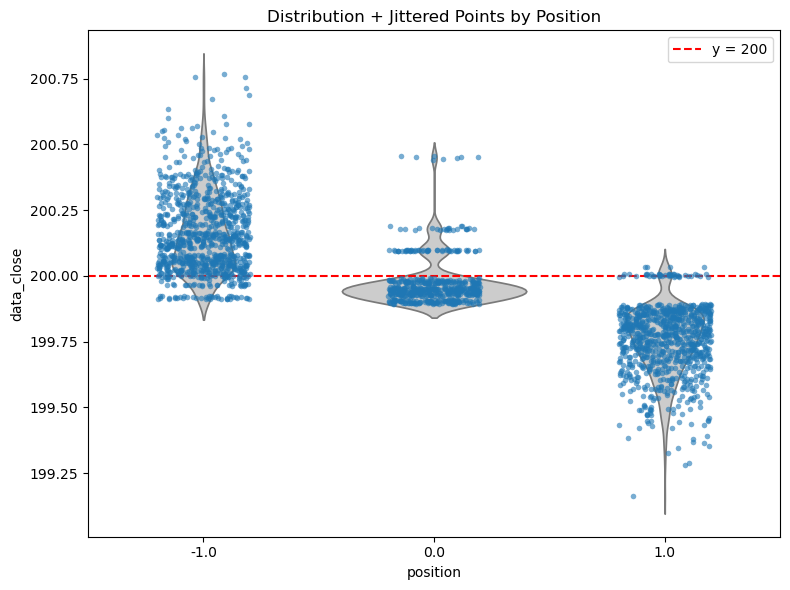

In [22]:
signals_df_xgb = pd.concat([buy_df_xgb, sell_df_xgb, exit_df_xgb])
plot_signals_distribution(signals_df_xgb, threshold=mu_epsilon)

In [23]:
len(signals_df_qlearning), len(signals_df_xgb)

(2266, 2352)

In [24]:
signals_df_qlearning["above"] = signals_df_qlearning["data_close"] > mu_epsilon
signals_df_qlearning.groupby(['position', 'above']).size().unstack(fill_value=0).rename(columns={False: f'≤ {mu_epsilon}', True: f'> {mu_epsilon}'})

above,≤ 200,> 200
position,,
-1.0,6,709
0.0,129,434
1.0,962,26


In [25]:
signals_df_xgb["above"] = signals_df_xgb["data_close"] > mu_epsilon
signals_df_xgb.groupby(['position', 'above']).size().unstack(fill_value=0).rename(columns={False: f'≤ {mu_epsilon}', True: f'> {mu_epsilon}'})

above,≤ 200,> 200
position,,
-1.0,101,851
0.0,452,80
1.0,834,34
